# FORCE Network
In this notebook the FORCE networks needed for Figure 2 are run. Developed for Julia 0.6.1.

Imports, including python libraries for saving the data.

In [1]:
include("../forceNetworks.jl")
using PyCall
using ProgressMeter
@pyimport numpy
@pyimport pandas
using PyPlot

Some network parameters

In [2]:
#Number of neurons
N = 1000

#Number of latent variables
D = 2

#Simulation timestep (seconds)
dt = 5e-5

#Piecewise constant signal to learn
signal = [0.2 0.6 0.0 -0.7 -0.2; 0.0 -0.3 0.2 0.0 0.5]
input = repeat(signal, inner=(1,Int(5e-1/dt)), outer=(1,20))

2×1000000 Array{Float64,2}:
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  …  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.5   0.5   0.5   0.5   0.5   0.5

Object for keeping track of the network

In [3]:
net = ForceNetwork.Network(ForceNetwork.NetworkParameters(),
                           ForceNetwork.NetworkMatrices(N, D, α=.1*dt, G=10.0),
                           ForceNetwork.NetworkState(N, D));

A couple of tricks are used in this function to make the FORCE networks faster and more stable. First, it is exposed to the training example only every tenth step, which speeds up run time considerably. Second, the network begins as a feed-forward network and the recurrent connections are introduced gradually (the `recFrac` variable). The network is tested by replacing the recurrent connections with an artifical input for 3000 time steps, and then the recurrent connections are reinstated for the next 7000 timesteps so that the network's ability to retain the pattern can be tested. Note that this is not a fair performance evalutation of FORCE networks because the same pattern is used for training and testing and it is therefore very prone to overfitting.

In [4]:
function trainAndRun!(network, input)
    T = size(input, 2)
    spikes = Vector{Tuple{Float64, Int64}}()
    x = zeros(T, 2)
    @ProgressMeter.showprogress 1 "Simulating..." for t=1:T
        target = t % 10 == 0 && t < .9T ? input[:,t] : nothing# && t % 2000 > 400 
        if t % 10000 < 3000
            ForceNetwork.step!(network, target, input[:,t], 0.0)
        else
            recFrac = max(1-t/(.8T), 0.0)
            ForceNetwork.step!(network, target, input[:,t], recFrac)
        end
        for n=1:1000
            if network.state.spiking[n]
                push!(spikes, (t*dt,n))
            end
        end
        x[t,:] = network.state.x
    end
    return x, spikes
end

trainAndRun! (generic function with 1 method)

Run the unperturbed network

In [5]:
x, spikes = trainAndRun!(net, input);

Simulating...100%|██████████████████████████████████████| Time: 0:35:12


Check that the network managed to learn

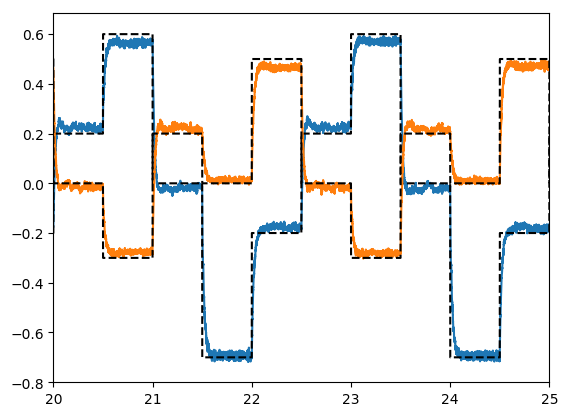

(20, 25)

In [6]:
plot((1:size(x,1))* dt, x[:,1])
plot((1:size(x,1)) * dt, input[1,:], "k--")#
plot((1:size(x,1))* dt, x[:,2])
plot((1:size(x,1)) * dt, input[2,:], "k--")#
xlim(20,25)

Write the unperturbed network data to a pytable-file for later analysis

In [7]:
filename = "../generatedData/fig2.h5"
pandas.DataFrame(net.matrices.η, columns=["K1", "K2"])[:to_hdf](filename, "/force/orignal/K")
pandas.DataFrame(net.matrices.Φ', columns=["phi1", "phi2"])[:to_hdf](filename, "/force/orignal/phi")
pandas.DataFrame(spikes, columns=["time", "neuron"])[:to_hdf](filename, "/force/orignal/x")
pandas.DataFrame(x, columns=["x1", "x2"])[:to_hdf](filename, "/force/orignal/spikes")

Create an inside-manifold perturbed network

In [12]:
permColMat = ForceNetwork.NetworkMatrices(net.matrices.Ω, .1*dt*eye(N), net.matrices.η[:, [2,1]], zeros(D, N))
permColnet = ForceNetwork.Network(ForceNetwork.NetworkParameters(), permColMat, ForceNetwork.NetworkState(N, D));

Run the perturbed network

In [ ]:
x, spikes = trainAndRun!(permColnet, input);

Simulating...  2%|█                                     |  ETA: 0:28:24

Write the perturbed data to the same file

In [ ]:
pandas.DataFrame(permColnet.matrices.η, columns=["K1", "K2"])[:to_hdf](filename, "/force/perturbed/K")
pandas.DataFrame(permColnet.matrices.Φ', columns=["phi1", "phi2"])[:to_hdf](filename, "/force/perturbed/phi")
pandas.DataFrame(spikes, columns=["time", "neuron"])[:to_hdf](filename, "/force/perturbed/x")
pandas.DataFrame(x, columns=["x1", "x2"])[:to_hdf](filename, "/force/perturbed/spikes")